In [1]:
# Navigate to the root of the project and import necessary libraries
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

device = 'cpu'

/tmp/ipykernel_7310/451883383.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")


In [ ]:
def show_row(row, highlights=None, all=False):

    file = files[row['page']]
    img_np = np.array(Image.open(image_folder / file))
    print(img_np.shape)

    
    
    # Draw rectangle on a copy of the image
    img_with_rect = img_np.copy()
    page_number = patches_df['page'][i]
    if all:
        selection = patches_df[patches_df['page'] == page_number]
        for _, row in selection.iterrows():
            left, top, w, h = row[['left', 'top', 'width', 'height']]
            cv2.rectangle(img_with_rect, (left, top), (left+w, top+h), (255, 185, 64), 8)


    if highlights is not None:

        selection = patches_df.iloc[highlights]
        selection = selection[selection['page'] == page_number]

        for _, row in selection.iterrows():
            left, top, w, h = row[['left', 'top', 'width', 'height']]
            cv2.rectangle(img_with_rect, (left, top), (left+w, top+h), (0, 255, 0), 8)

    left, top, w, h = row[['left', 'top', 'width', 'height']]
    cv2.rectangle(img_with_rect, (left, top), (left+w, top+h), (255, 0, 0), 8)


    # Display the image with rectangle
    plt.figure(figsize=(16,9))
    plt.imshow(img_with_rect)
    plt.title(f"Page: {row['page']}, Position: ({left}, {top}) ; filename: {file}")
    plt.axis('off')
    plt.show()




In [ ]:
# ==== Align the SVGs ====
# Not used at the moment
# We found that it did not really work well.

# from src.patch_processing.normalization import process_svg

# #? Show two examples for demo purposes
# scale = 4

# i = np.random.randint(0, len(svg_imgs))
# print(f'Visualizing index {i}')
# idx, svg_object = svg_imgs[i]
# process_svg(image=img_patches[idx], svg_object=svg_object, display=True, scale=scale)
# i = np.random.randint(0, len(svg_imgs))
# print(f'Visualizing index {i}')
# idx, svg_object = svg_imgs[i]
# process_svg(image=img_patches[idx], svg_object=svg_object, display=True, scale=scale)

# #! Process the rest
# scale = 1
# for i, (idx, svg_object) in enumerate(tqdm(svg_imgs, desc="Processing & saving SVGs", unit="svg", colour='magenta')):
#     process_svg(image=img_patches[idx], svg_object=svg_object, display=False, scale=scale)
#     svg_object.save(f'output_svg_aligned/output_{i:06d}.svg')


## Computation of the HOG descriptor

This notebook explains how we compute the HOG descriptor to match the different patches to characters. Let's begin by loading the actual patches:

In [2]:
from src.ocr.patch_extraction import extract_patches
from src.ocr.utils import connectedComponent, torch_to_pil
from PIL import Image
import torch

characterComponents = connectedComponent.load('data/extracted/components/filtered_characters.npz')
img_pil = Image.open('data/examples/ying_huan_zhi_lue_22_high.jpg').convert('L')

# patches, img_patches = extract_patches(characterComponents, image=np.array(img_pil), border=5)

- Calculer les gradients en utilisant la scale appropriée (c'est quoi la scale ?)
- Weight sur la magnitude des gradients -> Gaussian, sigma = window / 2
- Cells de 4x4 dans l'implémentation de base
- On ajoute à l'histogramme avec une interpolation trilinéaire: on ajoute au bin avec un poids dépendant de la distance avec le centre du bin
- On forme le vecteur
- On le normalise à un vecteur unité
- On threshold les valeurs de ce vecteur à 0.2 max et renormalise
- 

In [3]:
from src.ocr.feature_matching import HOG, HOGParameters, featureMatching, featureMatchingParameters

hog_params = HOGParameters(
    device          = "cuda",
    C               = 1, # use WB images
    partial_output  = False,
    method          = 'gaussian',
    grdt_sigma      = 3.5,
    ksize_factor    = 8,
    cell_height     = 16,
    cell_width      = 16,
    psize           = 128,
    num_bins        = 8,
    sigma           = 1,
    threshold       = 0.2
)

featureMatching_params = featureMatchingParameters(
    metric          = "L2",
    epsilon         = 0.005,
    reciprocal_only = True
)

hog = HOG(hog_params)
feature_matcher = featureMatching(featureMatching_params)


img_torch = torch.tensor(np.array(img_pil), device="cuda").unsqueeze(-1).permute(2,0,1).to(dtype=torch.float32) / 255
img_torch.requires_grad = False

hog_output = hog(img_torch, characterComponents)

In [4]:
from einops import rearrange

histograms = rearrange(hog_output.histograms, 'Npatch C Ncells Nbins -> Npatch Ncells (C Nbins)')

In [11]:
matches = feature_matcher(
    query_histograms=histograms,
    key_histograms=histograms
)

## Computing the gradients

We will compute the gradients of the smoothed image using pytorch convolutions. Let's begin by creating the filters:

In [7]:
kernels = {
    'central_differences':{
        'k': np.array([0,1,0]),
        'd': np.array([-.5,0,.5])
    },
    'hypomode':{
        'k': np.array([0,0.5,0.5]),
        'd': np.array([0,-1,1])
    },
    'farid_3x3': {
        'k': np.array([0.229879, 0.540242, 0.229879]),
        'd': np.array([-0.425287, 0, 0.425287])
    },
    'farid_5x5': {
        'k': np.array([0.037659, 0.249153, 0.426375, 0.249153, 0.037659]),
        'd': np.array([-0.109604, -0.276691, 0, 0.276691, 0.109604])
    }
}

In [8]:

import cv2
from torch import nn
from einops import rearrange



C = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sigma = 3.5


ksize = int(sigma*8) //2 * 2 + 1
k = cv2.getGaussianKernel(ksize, sigma)
d, _ = cv2.getDerivKernels(dx=1, dy=0, ksize=ksize, normalize=True)

# ksize = 5
# k = kernels['farid_5x5']['k']
# d = kernels['farid_5x5']['d']

plt.figure(figsize=(10,15))
plt.suptitle('Derivation kernels')
plt.subplot(3,2,1)
plt.title('Prefilter kernel')
plt.plot(k)
plt.subplot(3,2,2)
plt.title('Derivative kernel')

plt.plot(d)



dx_conv = nn.Sequential(
    nn.Conv2d(C, C, kernel_size=(1, ksize), padding=(0, ksize//2), bias=False, groups=C, padding_mode='reflect'),
    nn.Conv2d(C, C, kernel_size=(ksize, 1), padding=(ksize//2, 0), bias=False, groups=C, padding_mode='reflect')
).to(device).eval()

dy_conv = nn.Sequential(
    nn.Conv2d(C, C, kernel_size=(ksize, 1), padding=(ksize//2, 0), bias=False, groups=C, padding_mode='reflect'),
    nn.Conv2d(C, C, kernel_size=(1, ksize), padding=(0, ksize//2), bias=False, groups=C, padding_mode='reflect')
).to(device).eval()

pre_gradient_conv = nn.Sequential(
    nn.Conv2d(C, C, kernel_size=(ksize, 1), padding=(ksize//2, 0), bias=False, groups=C, padding_mode='reflect'),
    nn.Conv2d(C, C, kernel_size=(1, ksize), padding=(0, ksize//2), bias=False, groups=C, padding_mode='reflect')
).to(device).eval()

with torch.no_grad():
    for i in range(C):
        dx_conv[0].weight[i, 0, 0, :] = torch.tensor(k.flatten(), dtype=torch.float32, device=device)
        dx_conv[1].weight[i, 0, :, 0] = torch.tensor(d.flatten(), dtype=torch.float32, device=device)

        dy_conv[0].weight[i, 0, :, 0] = torch.tensor(k.flatten(), dtype=torch.float32, device=device)
        dy_conv[1].weight[i, 0, 0, :] = torch.tensor(d.flatten(), dtype=torch.float32, device=device)

        pre_gradient_conv[0].weight[i, 0, :, 0] = torch.tensor(k.flatten(), dtype=torch.float32, device=device)
        pre_gradient_conv[1].weight[i, 0, 0, :] = torch.tensor(k.flatten(), dtype=torch.float32, device=device)

pre_grad = pre_gradient_conv(img_torch)

plt.subplot(3,2,3)

plt.imshow(torch_to_pil(pre_grad, max_normalize=True), cmap="gray")
plt.title('After gradient preprocessing')

plt.subplot(3,2,4)

with torch.no_grad():
    dx = dx_conv(pre_grad)
    dy = dy_conv(pre_grad)

plt.imshow(torch_to_pil(dx, max_normalize=True), cmap="gray")
plt.colorbar()
plt.title('x-gradient')

plt.subplot(3,2,5)


plt.imshow(torch_to_pil(dy, max_normalize=True), cmap="gray")
plt.colorbar()
plt.title('y-gradient')


Text(0.5, 1.0, 'y-gradient')

Error in callback <function flush_figures at 0x7584b392fce0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Now, we compute the magnitude and 0-1 orientation of the gradients:

In [ ]:
magn = torch.sqrt(dx**2 + dy**2)
angle = torch.arctan2(dy, dx) / np.pi / 2 + .5

del dx, dy

torch_to_pil(magn, max_size=1024, max_normalize=True).show()
torch_to_pil(angle, max_size=1024, max_normalize=True).show()

Let's extract them into patches:

In [ ]:
def extract_patches(characterComponents: connectedComponent, images, border = None):
    """
    Extracts patches arround each character in characterComponents.
    """

    patches_list = []

    for image in images:
        if border is not None:
            if type(image) == np.ndarray:
                image = np.pad(image, border, mode='constant', constant_values=0)
            else:
                image = nn.functional.pad(image, (border, border), mode='constant', value=0)
        else:
            border = 0

        patches = []

        for region in characterComponents.regions:
            h1, w1, h2, w2 = region.bbox
            h2+=2*border; w2+=2*border

            patch = image[h1:h2, w1:w2] if type(image) == np.ndarray else image[..., h1:h2, w1:w2]
            patches.append(patch)

        patches_list.append(patches)
    
    return patches_list


extracted_magn_patches, extracted_ori_patches, extracted_image_patches = extract_patches(characterComponents, (magn, angle, img_torch))

In [ ]:
extracted_magn_patches.shape

torch.Size([473, 1, 128, 128])

We make them 128x128 patches using bilinear interpolation:

torch.Size([473, 1, 128, 128])


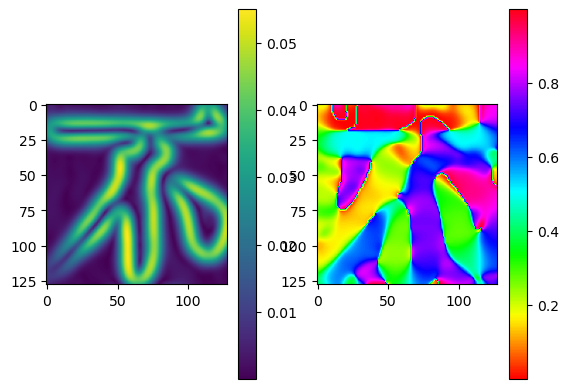

In [ ]:
def normalize(patch):
    return nn.functional.interpolate(patch, (128, 128), mode='bilinear')

extracted_magn_patches = [normalize(patch.unsqueeze(0)).squeeze(0) for patch in extracted_magn_patches]
extracted_magn_patches = torch.stack(extracted_magn_patches)

extracted_ori_patches = [normalize(patch.unsqueeze(0)).squeeze(0) for patch in extracted_ori_patches]
extracted_ori_patches = torch.stack(extracted_ori_patches)


plt.subplot(1,2,1)
plt.imshow(extracted_magn_patches[0].cpu().detach()[0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(extracted_ori_patches[0].cpu().detach()[0], cmap='hsv')
plt.colorbar()

print(extracted_magn_patches.shape) # B, C, Ph, Pw

## Histograms computation

We compute the histograms using trilinear interpolation, as mentionned in the IPOL paper.
We weight the contributions of the orientations by the product of their magnitude and a gaussian kernel, with $\sigma=1$ (for a window span of $[-1, 1]$).

Then, we normalize the histograms to unit norm, threshold the values above $0.2$, and renormalize it. In the end, we obtain a (N_cells, N_bins) vector per patch.


In [ ]:
def compute_hog_histograms_trilinear(magn_patches, ori_patches, cell_height=16, cell_width=16, num_bins=8, sigma=1):
    """
    Compute HOG histograms using trilinear interpolation with built-in functions.
    
    Args:
        magn_patches: shape (..., H, W)
        ori_patches: shape (..., H, W), 0-1
        num_bins: Number of orientation bins
    
    Returns:
        Histograms of shape (..., num_patches, num_bins)
    """
    device = magn_patches.device
    dtype = magn_patches.dtype

    # Divide the patch into cells

    magn_patches = rearrange(magn_patches, '... (h ch) (w cw) -> ... (h w) ch cw', 
                     ch=cell_height, cw=cell_width)

    ori_patches = rearrange(ori_patches, '... (h ch) (w cw) -> ... (h w) ch cw', 
                        ch=cell_height, cw=cell_width)
    
    assert ori_patches.max() <= 1 and ori_patches.min() >= 0, "The orientation must be between 0 and 1"

        
    # Normalize orientations to [0, num_bins) range
    ori_normalized = ori_patches * num_bins
    
    # Spatial distance weighting from cell center
    y = torch.linspace(-1, 1, cell_height, device=device, dtype=dtype)
    x = torch.linspace(-1, 1, cell_width, device=device, dtype=dtype)
    yy, xx = torch.meshgrid(y, x, indexing='ij')
    spatial_weight = torch.exp(-(yy**2 + x**2) / 2 / sigma)
    
    # Apply spatial weights to magnitudes
    weighted_magnitudes = magn_patches * spatial_weight
    
    # Flatten for bin assignment
    weighted_mag_flat = rearrange(weighted_magnitudes, '... h w -> ... (h w)')
    ori_flat = rearrange(ori_normalized, '... h w -> ... (h w)')
    
    # Orientation bin interpolation
    ori_floor = torch.floor(ori_flat).long() % num_bins
    ori_ceil = (ori_floor + 1) % num_bins
    ori_weight_ceil = ori_flat - torch.floor(ori_flat)
    ori_weight_floor = 1 - ori_weight_ceil
    
    # Split weighted magnitudes between adjacent bins
    contrib_floor = weighted_mag_flat * ori_weight_floor
    contrib_ceil = weighted_mag_flat * ori_weight_ceil
    
    # Use scatter_add to add to the histograms
    batch_shape = weighted_mag_flat.shape[:-1]
    histograms = torch.zeros(*batch_shape, num_bins, device=device, dtype=dtype)
    
    histograms.scatter_add_(dim=-1, index=ori_floor, src=contrib_floor)
    histograms.scatter_add_(dim=-1, index=ori_ceil, src=contrib_ceil)
    
    return histograms


In [ ]:
extracted_ori_patches.max()

tensor(1.0000, device='cuda:0')

In [ ]:
descriptor.shape

torch.Size([473, 1, 64, 8])

In [ ]:
descriptor = compute_hog_histograms_trilinear(
    extracted_magn_patches, extracted_ori_patches, num_bins=8
)


descriptor /= torch.norm(descriptor)
descriptor.clip_(-0.2, 0.2)
descriptor /= torch.norm(descriptor)

descriptor.shape

torch.Size([473, 1, 64, 8])

### Nearest neighbors

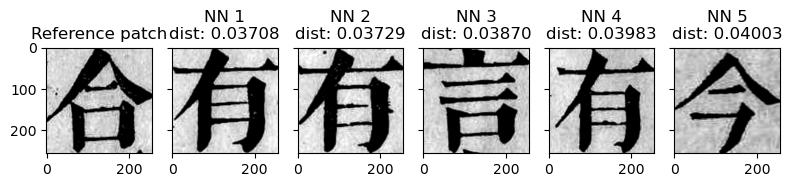

In [ ]:
descriptors_np = np.array(descriptor.detach().cpu())[:, 0]
descriptors_np = descriptors_np.reshape(len(descriptors_np), -1)

from sklearn.neighbors import NearestNeighbors
n_neighs = 5
nbrs = NearestNeighbors(n_neighbors=n_neighs + 1).fit(np.array(descriptors_np))  # +1 to include self

i = np.random.randint(0, len(descriptors_np))

desc = descriptors_np[i]
img_patch = extracted_image_patches[i]

distances, indices = nbrs.kneighbors(desc[None, :])

fig, axs = plt.subplots(1, n_neighs + 1, figsize=(8, 4), sharex=True, sharey=True)

# Reference patch
ax = axs[0]
ax.imshow(torch_to_pil(img_patch).resize((256,256)), cmap="gray")
ax.set_title('Reference patch')

# Nearest neighbors (skip the first result which is the reference patch itself)
for j, (idx, dist) in enumerate(zip(indices[0][1:], distances[0][1:]), 1):
    ax = axs[j]
    ax.imshow(torch_to_pil(extracted_image_patches[idx]).resize((256,256)), cmap="gray")
    ax.set_title(f'NN {j}\ndist: {dist:.5f}')

plt.tight_layout()
plt.show()

## Circular Earth Mover Distance (CEMD)

**Based on [this paper](https://hal.science/hal-00168285/document)**.

The Earth Mover Distance is the Wasserstein-1 metric, which compares two probability measures $\mu$ and $\nu$. In the general case, given a metric space $(M, c)$, it is formulated as $W_1(\mu, \nu) = \inf \limits_{\gamma \in \Gamma(\mu, \nu)} \mathbb{E}_{(x,y)\sim\gamma}\left[ c(x, y)\right]$, where $\Gamma(\mu, \nu)$ is the set of all couplings between $\mu$ and $\nu$. For two discrete histograms $f$ and $g$ with $N$ bins, their EMD is defined as $\text{EMD}(f, g) = \min_{\alpha_{i, j} \in \mathcal{M}} \sum \limits_{i=1}^N \sum \limits_{j=1}^N \alpha_{i,j} c(i, j)$, with $\mathcal{M}$ the set of all couplings between $f$ and $g$.

For circular histograms, we use:
$$c(i,j) = \frac{1}{N} \min(|i-j|, N - |i-j|), \quad \forall (i,j) \in \{1, \ldots N\}^2.$$

When the distance is $c(i, j) = \frac{1}{N} | i-j |$ (non-circular case), it is well-known that EMD equals the $\ell_1$ distance between cumulative histograms: $\text{EMD}(f, g) = \|F - G\|_1 = \frac{1}{N}\sum_{i=1}^N |F[i] - G[i]|$, where $F[i] = \sum_{j=1}^i f[j]$ and $G[i] = \sum_{j=1}^i g[j]$.

Rabin et al. proved that for circular histograms with the circular ground distance, the Circular Earth Mover's Distance (CEMD) can be efficiently computed as:

$$\text{CEMD}(f, g) = \min_{k \in \{1,\ldots N\}} \|F_k - G_k\|_1$$

where $F_k$ and $G_k$ are cumulative histograms of $f$ and $g$ starting at the $k$-th bin.

In [ ]:

## ! Temporary implementation. Needs batching ##
## ? Also needs to work with this signature:
## ? descs1: (N1, Nh, N_bins), descs2: (N2, Nh, N_bins) -> distances: (N1, N2, Nh)

f = descriptor
g = descriptor

F = f.cumsum(dim=-1)
G = g.cumsum(dim=-1)
X = F - G  # ..., N_bins

N = f.shape[-1]

# Compute ||X_k||_1 for each k
X_padded = torch.cat([torch.zeros_like(X[..., :1]), X], dim=-1)  # ..., N+1

l1_norms = []
for k in range(N):
    X_k = X - X_padded[..., k:k+1]  # Subtract X[k-1] from all positions
    l1_norm = X_k.abs().sum(dim=-1) / N
    l1_norms.append(l1_norm)

cemd = torch.stack(l1_norms, dim=-1).min(dim=-1).values

## Statistical test for descriptor matching

**Based on [this paper](https://hal.science/hal-00168285/document) and ideas by Aitor Artola**

### Framework and notation

Let $a^i = (a^i_1, \ldots, a^i_M)$ and $b = (b_1, \ldots, b_M)$ be two descriptor vectors with $M$ components (e.g., histograms).

**Global dissimilarity measure**:
$$D(a^i, b) = \sum_{m=1}^{M} d(a^i_m, b_m)$$
where $d(\cdot, \cdot)$ is a dissimilarity measure between components (Euclidean distance, Circular Earth Mover Distance, etc.).

### Null hypothesis

**$\mathcal{H}_0^i$**: The random variables $\{d(a^i_m, b_m)\}_{m=1}^M$ are mutually independent.

Under this hypothesis, each $d(a^i_m, b_m)$ is a random variable with density $p_m$, mean $\mu_m$, and variance $\sigma_m^2$.

### Probability under the null hypothesis

The probability that the global dissimilarity is below a threshold $\delta$ is:
$$\mathbb{P}\left(D(a^i, b) \leq \delta \mid \mathcal{H}_0^i\right) = \mathbb{P}\left(\sum_{m=1}^{M} d(a^i_m, b_m) \leq \delta\right)$$

This probability corresponds to the cumulative distribution function of the sum of independent random variables:
$$\mathbb{P}\left(D(a^i, b) \leq \delta \mid \mathcal{H}_0^i\right) = (p_1 * p_2 * \cdots * p_M)(\delta)$$
where $*$ denotes convolution.

### Normal approximation (CLT)

**Theorem (Lindeberg-Feller CLT)**: Let $X_m = d(a^i_m, b_m)$ be independent random variables with $\mathbb{E}[X_m] = \mu_m$ and $\text{Var}(X_m) = \sigma_m^2$. Define:
$$S_M = \sum_{m=1}^M X_m, \quad s_M^2 = \sum_{m=1}^M \sigma_m^2$$

Under appropriate regularity conditions (Lindeberg condition and Feller condition), we have:
$$\frac{S_M - \mathbb{E}[S_M]}{s_M} = \frac{\sum_{m=1}^M (X_m - \mu_m)}{s_M} \xrightarrow[\text{dist}]{M \to \infty} \mathcal{N}(0, 1)$$

**In practice**, for fixed and sufficiently large $M$, under $\mathcal{H}_0^i$:
$$D(a^i, b) \approx \mathcal{N}\left(\mu_{\text{tot}}, \sigma_{\text{tot}}^2\right)$$
with $\mu_{\text{tot}} = \sum_{m=1}^M \mu_m$ and $\sigma_{\text{tot}}^2 = \sum_{m=1}^M \sigma_m^2$ (finite quantities).

This approximation is justified when:
1. The $d(a^i_m, b_m)$ are independent
2. The Feller condition is verified
3. $M$ is large enough for the normal approximation to be accurate

### Statistical test

We compute the $p$-value:
$$p\text{-value} = \mathbb{P}\left(D(a^i, b) \leq \delta_{\text{obs}} \mid \mathcal{H}_0^i\right) \approx \Phi\left(\frac{\delta_{\text{obs}} - \mu_{\text{tot}}}{\sigma_{\text{tot}}}\right)$$
where $\Phi$ is the cumulative distribution function of the standard normal distribution.

We reject $\mathcal{H}_0^i$ (the descriptors do not match) if this $p$-value is too low. When comparing $N_Q$ query descriptors against $N_C$ candidates, the matching threshold for a given $\varepsilon > 0$ is obtained by finding the largest $\delta$ such that:
$$\Phi\left(\frac{\delta - \mu_{\text{tot}}}{\sigma_{\text{tot}}}\right) \leq \frac{\varepsilon}{N_Q N_C}$$

Since $\Phi$ is monotonically increasing, this gives:
$$\frac{\delta_i(\varepsilon) - \mu_{\text{tot}}}{\sigma_{\text{tot}}} = \Phi^{-1}\left(\frac{\varepsilon}{N_Q N_C}\right)$$

Therefore:
$$\delta_i(\varepsilon) = \mu_{\text{tot}} + \sigma_{\text{tot}} \cdot \Phi^{-1}\left(\frac{\varepsilon}{N_Q N_C}\right)$$

A match between $a^i$ and $b^j$ is **$\varepsilon$-meaningful** if $D(a^i, b^j) \leq \delta_i(\varepsilon)$. Under $\mathcal{H}_0^i$, the expected number of $\varepsilon$-meaningful matches is bounded by $\varepsilon$.

In [ ]:
match_indices_non_reciprocal.shape

torch.Size([4034, 2])

In [ ]:
distances.shape

torch.Size([472, 473, 64])

In [ ]:
delta.shape

torch.Size([472])

In [ ]:
from torch.distributions import Normal


epsilon = 0.005  # Expected number of false detections

# distances = torch.rand((N1, N2, Nh))
distances = torch.log(((descriptor[None,:, 0]-descriptor[1:])**2).sum(-1).detach()+1e-5)
# distances = ((descriptor[None,:, 0]-descriptor)**2).sum(-1).detach()

N1, N2, Nh = distances.shape
mu_tot   = distances.mean(dim=1).sum(-1)  # (N1,)
var_tot  = distances.var(dim=1).sum(-1)   # (N1,)

standard_normal = Normal(0, 1)
delta = mu_tot + var_tot**.5 * standard_normal.icdf(torch.tensor(epsilon / (N1 * N2)))

# Compute total distance D(a^i, b^j) for all pairs
D = distances.sum(dim=-1)  # (N1, N2)

# Find ε-meaningful matches: D(a^i, b^j) <= delta_i(ε)
matches = D <= delta.unsqueeze(1)  # (N1, N2) boolean mask

matches_reciprocal = torch.logical_and(matches, matches.T)

# Get match indices (query_idx, candidate_idx)
match_indices_non_reciprocal = torch.nonzero(matches, as_tuple=False)  # (num_matches, 2)
match_indices_reciprocal = torch.nonzero(matches_reciprocal, as_tuple=False)

match_indices = match_indices_reciprocal

RuntimeError: The size of tensor a (473) must match the size of tensor b (472) at non-singleton dimension 1

In [ ]:
data = D.cpu().reshape(-1)
data = data[data != 0]

In [ ]:
from fitter import Fitter

# Fit data to common distributions
f = Fitter(data, distributions=['norm'])
f.fit()

# Get summary of best fits
print(f.summary())

# Plot results
f.plot_pdf()
plt.show()

      sumsquare_error          aic          bic  kl_div  ks_statistic  \
norm         0.131661  1032.110486  1052.746867     inf       0.03615   

          ks_pvalue  
norm  1.815505e-254  


2025-11-04 15:03:39.044 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.131661)


In [ ]:
# Pick a random query
i = np.random.randint(0, N1)

# Get all matches for query i from the statistical test
query_matches = match_indices[match_indices[:, 0] == i][:, 1]  # Candidate indices that match query i

# Compute distances from query i to all candidates
D_i = D[i].detach().cpu().numpy()  # Distance to all N2 candidates

# Get sorted candidate indices by distance (nearest first)
sorted_indices = np.argsort(D_i)
sorted_distances = D_i[sorted_indices]

# Determine which are accepted (ε-meaningful matches)
n_to_show = min(5, N2)
accepted_mask = np.isin(sorted_indices[:n_to_show], query_matches.cpu().numpy())

# Plot distances with color coding
plt.figure(figsize=(8, 3))
colors = ['green' if accepted else 'red' for accepted in accepted_mask]
plt.scatter(range(1, n_to_show + 1), sorted_distances[:n_to_show], c=colors, s=100, zorder=3)

# Add threshold line
thresh_value = delta[i].item()
plt.axhline(y=thresh_value, color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold δ_i(ε) = {thresh_value:.3f}')

# Shade rejected region
plt.axhspan(thresh_value, sorted_distances[:n_to_show].max() * 1.1, alpha=0.2, 
            color='red', label='Rejected region')

plt.xlabel('Nearest Neighbor Rank', fontsize=11)
plt.ylabel('Distance D(a^i, b^j)', fontsize=11)
plt.title(f'Statistical Test: Query {i} (ε={epsilon}, {len(query_matches)} matches)', 
          fontsize=12, fontweight='bold')
plt.xticks(range(1, n_to_show + 1))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize patches with acceptance/rejection status
fig, axs = plt.subplots(1, n_to_show + 1, figsize=(10, 4), sharex=True, sharey=True)

# Reference patch (query)
ax = axs[0]
ax.imshow(torch_to_pil(extracted_image_patches[i]).resize((256, 256)), cmap="gray")
ax.set_title('Query patch', fontweight='bold')
ax.axis('off')

# Nearest neighbors with acceptance/rejection status
for j in range(n_to_show):
    candidate_idx = sorted_indices[j]
    distance = sorted_distances[j]
    
    ax = axs[j + 1]
    ax.imshow(torch_to_pil(extracted_image_patches[candidate_idx]).resize((256, 256)), cmap="gray")
    
    # Determine if this neighbor is accepted
    is_accepted = accepted_mask[j]
    status = '✓ ACCEPTED' if is_accepted else '❌ Rejected'
    color = 'green' if is_accepted else 'red'
    
    ax.set_title(f'NN {j+1}\ndist: {distance:.3f}\n{status}', 
                 fontweight='bold', color=color, fontsize=9)
    ax.axis('off')
    
    # Add colored border
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)
        spine.set_visible(True)

plt.suptitle(f'ε-Meaningful Matches (ε={epsilon}, δ={thresh_value:.3f})', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_27309/135245249.py:76: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/home/mathis/anaconda3/lib/python3.12/tkinter/__init__.py:861: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  func(*args)


In [ ]:
%matplotlib tk

match_indices = match_indices_reciprocal

In [ ]:
plt.hist(np.exp(D_i / 2000).reshape(-1), bins=30)

(array([ 1.,  1.,  3.,  2.,  1.,  0.,  0.,  1.,  5., 10., 20., 32., 68.,
        82., 81., 56., 38., 28., 17.,  7.,  6.,  4.,  2.,  1.,  3.,  0.,
         2.,  0.,  1.,  1.]),
 array([0.80167806, 0.80175346, 0.8018288 , 0.8019042 , 0.8019796 ,
        0.80205494, 0.80213034, 0.80220568, 0.80228108, 0.80235648,
        0.80243182, 0.80250722, 0.80258262, 0.80265796, 0.80273336,
        0.80280876, 0.8028841 , 0.8029595 , 0.80303484, 0.80311024,
        0.80318564, 0.80326098, 0.80333638, 0.80341178, 0.80348712,
        0.80356252, 0.80363786, 0.80371326, 0.80378866, 0.803864  ,
        0.8039394 ]),
 <BarContainer object of 30 artists>)

In [ ]:
# ============================================
# UMAP with ALL Image Patches - Fixed N calculation
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import networkx as nx
from umap import UMAP
import random

# Determine actual number of nodes from match_indices and distance matrix
if len(match_indices) > 0:
    max_query_idx = match_indices[:, 0].max().item()
    max_candidate_idx = match_indices[:, 1].max().item()
    N = max(max_query_idx, max_candidate_idx) + 1
else:
    N = D.shape[0]

print(f"Detected N = {N} descriptors (not N1={N1})")
print(f"Distance matrix shape: {D.shape}")
print(f"Match indices shape: {match_indices.shape}")

# Verify the distance matrix matches
assert D.shape[0] == N and D.shape[1] == N, f"Distance matrix shape mismatch: {D.shape} vs N={N}"

# Compute UMAP embedding
print("Computing UMAP embedding...")
distance_matrix = D.cpu().numpy()
umap_reducer = UMAP(n_components=2, metric='precomputed', 
                   n_neighbors=min(15, N-1), random_state=42)
coords_umap = umap_reducer.fit_transform(np.exp(distance_matrix))

# Build graph
print("Building graph...")
G = nx.Graph()
G.add_nodes_from(range(N))
edges = [(int(i.item()), int(j.item())) for i, j in match_indices if i != j]
G.add_edges_from(edges)

# Compute degrees
degrees = np.array([G.degree(i) for i in range(N)])

# Detect communities
print("Detecting communities...")
if G.number_of_edges() > 0:
    from networkx.algorithms import community
    communities = list(community.greedy_modularity_communities(G))
else:
    communities = [[i] for i in range(N)]

# Create node -> community mapping
community_map = {}
for comm_idx, comm in enumerate(communities):
    for node in comm:
        community_map[int(node)] = comm_idx

node_communities = np.array([community_map.get(i, 0) for i in range(N)])

print(f"Graph: {N} nodes, {G.number_of_edges()} edges, {len(communities)} communities")

# Generate random distinct colors for communities
def get_random_colors(n, seed=42):
    """Generate n random but distinct colors"""
    random.seed(seed)
    np.random.seed(seed)
    
    colors = []
    for _ in range(n):
        hue = random.random()
        saturation = 0.6 + random.random() * 0.4
        value = 0.7 + random.random() * 0.3
        
        import colorsys
        r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
        colors.append([r, g, b, 1.0])
    
    return np.array(colors)

n_communities = len(communities)
community_colors = get_random_colors(n_communities)

# ============================================
# Visualization
# ============================================

indices_to_show = np.arange(N)
print(f"Showing all {N} patches")

# Check if we have enough patches
print(f"Available patches: {len(extracted_image_patches)}")
assert len(extracted_image_patches) >= N, f"Not enough patches! Have {len(extracted_image_patches)}, need {N}"

# Adjust patch display size based on number of patches
if N < 50:
    display_size = 64
    zoom = 1.0
elif N < 200:
    display_size = 48
    zoom = 0.8
elif N < 500:
    display_size = 32
    zoom = 0.6
else:
    display_size = 24
    zoom = 0.5

print(f"Using display size: {display_size}px, zoom: {zoom}")

# Create figure with high DPI for better rendering
fig, ax = plt.subplots(figsize=(24, 20), dpi=100)

# Draw edges colored by community
show_edges = G.number_of_edges() < 2000
if show_edges:
    print("Drawing edges by community...")
    
    intra_community_edges = {i: [] for i in range(n_communities)}
    inter_community_edges = []
    
    for i, j in G.edges():
        comm_i = community_map.get(int(i), -1)
        comm_j = community_map.get(int(j), -1)
        
        if comm_i == comm_j and comm_i >= 0:
            intra_community_edges[comm_i].append((i, j))
        else:
            inter_community_edges.append((i, j))
    
    # Draw intra-community edges
    for comm_idx, edges_list in intra_community_edges.items():
        if len(edges_list) > 0:
            color = community_colors[comm_idx]
            for i, j in edges_list:
                ax.plot([coords_umap[i, 0], coords_umap[j, 0]], 
                       [coords_umap[i, 1], coords_umap[j, 1]], 
                       color=color, alpha=0.4, linewidth=1.0, zorder=1)
    
    # Draw inter-community edges
    for i, j in inter_community_edges:
        ax.plot([coords_umap[i, 0], coords_umap[j, 0]], 
               [coords_umap[i, 1], coords_umap[j, 1]], 
               'lightgray', alpha=0.1, linewidth=0.3, zorder=0)
    
    print(f"  {sum(len(e) for e in intra_community_edges.values())} intra-community edges")
    print(f"  {len(inter_community_edges)} inter-community edges")

# Add all patches
print("Adding patches...")
for idx in indices_to_show:
    # Get patch as PIL image  
    patch = extracted_image_patches[idx]
    pil_img = torch_to_pil(patch).resize((display_size, display_size), Image.Resampling.LANCZOS)
    
    # Create OffsetImage with proper zoom
    imagebox = OffsetImage(pil_img, zoom=zoom, cmap='gray')
    
    # Border color by community
    comm_idx = community_map.get(idx, 0)
    border_color = community_colors[comm_idx]
    
    # Border width by degree
    if len(degrees[degrees > 0]) > 0:
        degree_percentile = np.percentile(degrees[degrees > 0], [50, 80])
        if degrees[idx] > degree_percentile[1]:
            border_width = 2.5
        elif degrees[idx] > degree_percentile[0]:
            border_width = 2.0
        else:
            border_width = 1.5
    else:
        border_width = 1.5
    
    # Create AnnotationBbox at UMAP coordinates
    ab = AnnotationBbox(
        imagebox, 
        (coords_umap[idx, 0], coords_umap[idx, 1]),
        frameon=True,
        pad=0.0,
        bboxprops=dict(
            edgecolor=border_color,
            linewidth=border_width,
            facecolor='white',
            alpha=1.0
        ),
        zorder=10
    )
    ax.add_artist(ab)

# Set limits with some padding
margin = 3
ax.set_xlim(coords_umap[:, 0].min() - margin, coords_umap[:, 0].max() + margin)
ax.set_ylim(coords_umap[:, 1].min() - margin, coords_umap[:, 1].max() + margin)
ax.set_aspect('equal')
ax.axis('off')

ax.set_title(f'UMAP Embedding with ALL {N} Image Patches\n'
            f'{len(communities)} communities (random colors), {G.number_of_edges()} edges | '
            f'Border: color=community, width=degree', 
            fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"✓ All {N} patches displayed with {len(communities)} random community colors")

# Print community statistics
print("\nLargest communities:")
community_sizes = [(i, len(comm)) for i, comm in enumerate(communities)]
community_sizes.sort(key=lambda x: x[1], reverse=True)
for i, (comm_idx, size) in enumerate(community_sizes[:10], 1):
    print(f"  {i}. Community {comm_idx}: {size} nodes")
if len(communities) > 10:
    print(f"  ... and {len(communities) - 10} more communities")

Detected N = 473 descriptors (not N1=473)
Distance matrix shape: torch.Size([473, 473])
Match indices shape: torch.Size([2099, 2])
Computing UMAP embedding...


/home/mathis/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mathis/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Building graph...
Detecting communities...
Graph: 473 nodes, 813 edges, 182 communities
Showing all 473 patches
Available patches: 473
Using display size: 32px, zoom: 0.6
Drawing edges by community...
  792 intra-community edges
  21 inter-community edges
Adding patches...
✓ All 473 patches displayed with 182 random community colors

Largest communities:
  1. Community 0: 29 nodes
  2. Community 1: 21 nodes
  3. Community 2: 19 nodes
  4. Community 3: 15 nodes
  5. Community 4: 15 nodes
  6. Community 5: 14 nodes
  7. Community 6: 12 nodes
  8. Community 7: 10 nodes
  9. Community 8: 9 nodes
  10. Community 9: 9 nodes
  ... and 172 more communities


In [ ]:
120/400*100

30.0

In [ ]:
# ============================================
# Community Statistics and Analysis
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import networkx as nx

# Create undirected version if not exists
if 'G_undirected' not in locals():
    if G.is_directed():
        G_undirected = G.to_undirected()
    else:
        G_undirected = G

# Compute degrees if not already computed
if 'in_degrees' not in locals():
    if G.is_directed():
        in_degrees = np.array([G.in_degree(i) for i in range(N)])
        out_degrees = np.array([G.out_degree(i) for i in range(N)])
    else:
        # For undirected graphs, in_degree = out_degree = degree
        in_degrees = np.array([G.degree(i) for i in range(N)])
        out_degrees = np.array([G.degree(i) for i in range(N)])
    
if 'degrees' not in locals():
    if G.is_directed():
        degrees = in_degrees + out_degrees
    else:
        degrees = np.array([G.degree(i) for i in range(N)])

print("=" * 70)
print("COMMUNITY STATISTICS")
print("=" * 70)

# Basic statistics
print(f"\nGraph type: {'Directed' if G.is_directed() else 'Undirected'}")
print(f"Total nodes: {N}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Total communities: {len(communities)}")
print(f"Graph density: {nx.density(G_undirected):.4f}")

# Modularity (measure of community structure quality)
if G_undirected.number_of_edges() > 0:
    from networkx.algorithms import community as comm_module
    modularity = comm_module.modularity(G_undirected, communities)
    print(f"Modularity: {modularity:.4f} (higher is better, typically 0.3-0.7 is good)")

# Community size statistics
community_sizes = [len(comm) for comm in communities]
print(f"\nCommunity size statistics:")
print(f"  Mean: {np.mean(community_sizes):.2f}")
print(f"  Median: {np.median(community_sizes):.2f}")
print(f"  Min: {np.min(community_sizes)}")
print(f"  Max: {np.max(community_sizes)}")
print(f"  Std: {np.std(community_sizes):.2f}")

# Largest communities
print(f"\nTop 10 largest communities:")
sorted_communities = sorted(enumerate(communities), key=lambda x: len(x[1]), reverse=True)
for rank, (comm_idx, comm) in enumerate(sorted_communities[:10], 1):
    print(f"  {rank}. Community {comm_idx}: {len(comm)} nodes ({100*len(comm)/N:.1f}%)")

# Degree statistics per community
print(f"\nDegree statistics by community (top 5):")
for comm_idx, comm in sorted_communities[:5]:
    comm_degrees = degrees[list(comm)]
    if G.is_directed():
        comm_in = in_degrees[list(comm)]
        comm_out = out_degrees[list(comm)]
        print(f"  Community {comm_idx} ({len(comm)} nodes):")
        print(f"    Avg degree: {comm_degrees.mean():.2f} (in: {comm_in.mean():.2f}, out: {comm_out.mean():.2f})")
        print(f"    Max degree: {comm_degrees.max()} (in: {comm_in.max()}, out: {comm_out.max()})")
    else:
        print(f"  Community {comm_idx} ({len(comm)} nodes):")
        print(f"    Avg degree: {comm_degrees.mean():.2f}")
        print(f"    Max degree: {comm_degrees.max()}")

# Edge analysis
intra_edges = sum(1 for i, j in G.edges() 
                  if community_map.get(i, -1) == community_map.get(j, -1))
inter_edges = G.number_of_edges() - intra_edges
print(f"\nEdge distribution:")
print(f"  Intra-community edges: {intra_edges} ({100*intra_edges/G.number_of_edges():.1f}%)")
print(f"  Inter-community edges: {inter_edges} ({100*inter_edges/G.number_of_edges():.1f}%)")

# ============================================
# Visualizations
# ============================================

fig = plt.figure(figsize=(20, 12))

# 1. Community size distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(community_sizes, bins=min(30, len(communities)), 
         color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Community Size', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Community Size Distribution', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. Top communities pie chart
ax2 = plt.subplot(2, 3, 2)
top_n = 10
top_communities = sorted_communities[:top_n]
top_sizes = [len(comm) for _, comm in top_communities]
other_size = N - sum(top_sizes)

if other_size > 0:
    labels = [f'C{idx} ({len(comm)})' for idx, comm in top_communities] + [f'Others ({other_size})']
    sizes = top_sizes + [other_size]
    colors_pie = [community_colors[idx] for idx, _ in top_communities] + [[0.8, 0.8, 0.8, 1.0]]
else:
    labels = [f'C{idx} ({len(comm)})' for idx, comm in top_communities]
    sizes = top_sizes
    colors_pie = [community_colors[idx] for idx, _ in top_communities]

ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Top {top_n} Communities Distribution', fontsize=13, fontweight='bold')

# 3. Degree distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(degrees, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Total Degree', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Node Degree Distribution', fontsize=13, fontweight='bold')
ax3.axvline(degrees.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {degrees.mean():.1f}')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. In-degree vs Out-degree scatter (only for directed graphs)
ax4 = plt.subplot(2, 3, 4)
if G.is_directed():
    scatter = ax4.scatter(out_degrees, in_degrees, c=node_communities, 
                         cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Out-Degree', fontsize=12)
    ax4.set_ylabel('In-Degree', fontsize=12)
    ax4.set_title('In-Degree vs Out-Degree (colored by community)', fontsize=13, fontweight='bold')
    ax4.plot([0, max(out_degrees.max(), in_degrees.max())], 
             [0, max(out_degrees.max(), in_degrees.max())], 
             'r--', alpha=0.5, label='Equal in/out')
    ax4.legend()
else:
    # For undirected graph, show degree vs community size
    comm_sizes_per_node = [len(communities[community_map.get(i, 0)]) for i in range(N)]
    scatter = ax4.scatter(comm_sizes_per_node, degrees, c=node_communities,
                         cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Community Size', fontsize=12)
    ax4.set_ylabel('Node Degree', fontsize=12)
    ax4.set_title('Degree vs Community Size (colored by community)', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. Community connectivity matrix (top communities)
ax5 = plt.subplot(2, 3, 5)
top_comm_indices = [idx for idx, _ in sorted_communities[:10]]
connectivity_matrix = np.zeros((len(top_comm_indices), len(top_comm_indices)))

for i, j in G.edges():
    comm_i = community_map.get(i, -1)
    comm_j = community_map.get(j, -1)
    if comm_i in top_comm_indices and comm_j in top_comm_indices:
        i_idx = top_comm_indices.index(comm_i)
        j_idx = top_comm_indices.index(comm_j)
        connectivity_matrix[i_idx, j_idx] += 1
        if not G.is_directed() and i != j:
            # For undirected graphs, count both directions
            connectivity_matrix[j_idx, i_idx] += 1

im = ax5.imshow(connectivity_matrix, cmap='YlOrRd', aspect='auto')
ax5.set_xticks(range(len(top_comm_indices)))
ax5.set_yticks(range(len(top_comm_indices)))
ax5.set_xticklabels([f'C{idx}' for idx in top_comm_indices], rotation=45)
ax5.set_yticklabels([f'C{idx}' for idx in top_comm_indices])
if G.is_directed():
    ax5.set_xlabel('To Community', fontsize=12)
    ax5.set_ylabel('From Community', fontsize=12)
else:
    ax5.set_xlabel('Community', fontsize=12)
    ax5.set_ylabel('Community', fontsize=12)
ax5.set_title('Top 10 Communities Connectivity', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax5, label='Number of edges')

# 6. Nodes per community (top 20)
ax6 = plt.subplot(2, 3, 6)
top_20_communities = sorted_communities[:20]
comm_labels = [f'C{idx}' for idx, _ in top_20_communities]
comm_sizes_top = [len(comm) for _, comm in top_20_communities]
colors_bars = [community_colors[idx] for idx, _ in top_20_communities]

bars = ax6.barh(range(len(comm_labels)), comm_sizes_top, color=colors_bars, edgecolor='black')
ax6.set_yticks(range(len(comm_labels)))
ax6.set_yticklabels(comm_labels)
ax6.set_xlabel('Number of Nodes', fontsize=12)
ax6.set_ylabel('Community', fontsize=12)
ax6.set_title('Top 20 Communities by Size', fontsize=13, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# Additional Analysis
# ============================================

print("\n" + "=" * 70)
print("ISOLATED NODES AND HUBS")
print("=" * 70)

# Isolated nodes
isolated = [i for i in range(N) if degrees[i] == 0]
print(f"\nIsolated nodes (degree = 0): {len(isolated)}")
if len(isolated) > 0 and len(isolated) <= 10:
    print(f"  Node indices: {isolated}")

# Hub nodes (high degree)
degree_threshold = np.percentile(degrees[degrees > 0], 90) if len(degrees[degrees > 0]) > 0 else 0
hubs = [(i, degrees[i], in_degrees[i], out_degrees[i]) 
        for i in range(N) if degrees[i] >= degree_threshold]
hubs.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop 10 hub nodes (≥ 90th percentile degree = {degree_threshold:.0f}):")
for rank, (node, deg, in_deg, out_deg) in enumerate(hubs[:10], 1):
    comm = community_map.get(node, -1)
    if G.is_directed():
        print(f"  {rank}. Node {node}: degree={deg} (in={in_deg}, out={out_deg}), community={comm}")
    else:
        print(f"  {rank}. Node {node}: degree={deg}, community={comm}")

# Inter-community bridge nodes
print(f"\nBridge nodes (nodes connecting multiple communities):")
bridge_nodes = []
for node in range(N):
    neighbors_communities = set()
    for neighbor in G.neighbors(node):
        neighbors_communities.add(community_map.get(neighbor, -1))
    if len(neighbors_communities) > 1:
        bridge_nodes.append((node, len(neighbors_communities), degrees[node]))

bridge_nodes.sort(key=lambda x: (x[1], x[2]), reverse=True)
print(f"  Total bridge nodes: {len(bridge_nodes)}")
if len(bridge_nodes) > 0:
    print(f"  Top 10 bridges:")
    for rank, (node, n_comms, deg) in enumerate(bridge_nodes[:10], 1):
        print(f"    {rank}. Node {node}: connects {n_comms} communities, degree={deg}")

print("\n" + "=" * 70)

COMMUNITY STATISTICS

Graph type: Undirected
Total nodes: 473
Total edges: 791
Total communities: 187
Graph density: 0.0071
Modularity: 0.9112 (higher is better, typically 0.3-0.7 is good)

Community size statistics:
  Mean: 2.53
  Median: 1.00
  Min: 1
  Max: 39
  Std: 4.09

Top 10 largest communities:
  1. Community 0: 39 nodes (8.2%)
  2. Community 1: 29 nodes (6.1%)
  3. Community 2: 15 nodes (3.2%)
  4. Community 3: 15 nodes (3.2%)
  5. Community 4: 13 nodes (2.7%)
  6. Community 5: 10 nodes (2.1%)
  7. Community 6: 10 nodes (2.1%)
  8. Community 7: 9 nodes (1.9%)
  9. Community 8: 9 nodes (1.9%)
  10. Community 9: 8 nodes (1.7%)

Degree statistics by community (top 5):
  Community 0 (39 nodes):
    Avg degree: 7.33
    Max degree: 17
  Community 1 (29 nodes):
    Avg degree: 7.69
    Max degree: 12
  Community 2 (15 nodes):
    Avg degree: 4.53
    Max degree: 6
  Community 3 (15 nodes):
    Avg degree: 13.87
    Max degree: 14
  Community 4 (13 nodes):
    Avg degree: 9.08
    M